## simple example

In [1]:
import numpy as np
import tensorflow as tf
import os

# plotting pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# Helper to make the output consistent
SEED = 42
def reset_graph(seed=SEED):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

# set log level to supress messages, unless an error
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Check TensorFlow version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check if using GPU
if not tf.test.gpu_device_name():
    print('No GPU found')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    
reset_graph()

TensorFlow Version: 1.3.0
No GPU found


Extracting ../mnist_data/train-images-idx3-ubyte.gz
Extracting ../mnist_data/train-labels-idx1-ubyte.gz
Extracting ../mnist_data/t10k-images-idx3-ubyte.gz
Extracting ../mnist_data/t10k-labels-idx1-ubyte.gz


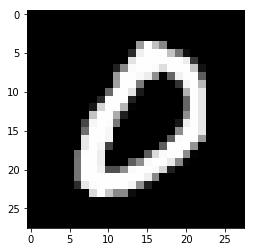

In [2]:
# import dataset (should already be present)
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../mnist_data', validation_size=0)


# ------ Make sure we're up and running
# display, random, single image
img = mnist.train.images[np.random.randint(6000, size=1)]

# mnist is 28x28 = 784 and is grayscale
# meaning, the 784 vector needs to be reshaped to 28,28
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [3]:
# my validation size is off for some reason.....
#  - will use test as validation (becuase we're not actually using this data for anything)
print(mnist.train.labels.shape)
print(mnist.test.labels.shape)
print(mnist.validation.labels.shape)

(60000,)
(10000,)
(0,)


In [4]:
he_init = tf.contrib.layers.variance_scaling_initializer() # He initialization
#Equivalent to:
#he_init = lambda shape, dtype=tf.float32: tf.truncated_normal(shape, 0., stddev=np.sqrt(2/shape[0]))

l2_regularizer = tf.contrib.layers.l2_regularizer(0.001)

In [5]:
reset_graph()

n_inputs = 28 * 28  # MNIST
n_hidden1 = 300
n_hidden2 = 100
n_outputs = 10

n_epochs = 5
batch_size = 64
learning_rate = 0.01

# activation function
def selu(z,
         scale=1.0507009873554804934193349852946,
         alpha=1.6732632423543772848170429916717):
    return scale * tf.where(z >= 0.0, z, alpha * tf.nn.elu(z))

In [6]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int64, shape=(None), name="y")

with tf.name_scope("dnn"):
    hidden1 = tf.layers.dense(X, n_hidden1, activation=selu, name="hidden1")
    hidden2 = tf.layers.dense(hidden1, n_hidden2, activation=selu, name="hidden2")
    logits = tf.layers.dense(hidden2, n_outputs, name="outputs")

with tf.name_scope("loss"):
    xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)
    loss = tf.reduce_mean(xentropy, name="loss")

with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(learning_rate)
    training_op = optimizer.minimize(loss)

with tf.name_scope("eval"):
    correct = tf.nn.in_top_k(logits, y, 1)
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [7]:
def get_model_params():
    gvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES)
    return {gvar.op.name: value for gvar, value in zip(gvars, tf.get_default_session().run(gvars))}

def restore_model_params(model_params):
    gvar_names = list(model_params.keys())
    assign_ops = {gvar_name: tf.get_default_graph().get_operation_by_name(gvar_name + "/Assign")
                  for gvar_name in gvar_names}
    init_values = {gvar_name: assign_op.inputs[1] for gvar_name, assign_op in assign_ops.items()}
    feed_dict = {init_values[gvar_name]: model_params[gvar_name] for gvar_name in gvar_names}
    tf.get_default_session().run(assign_ops, feed_dict=feed_dict)

In [8]:
means = mnist.train.images.mean(axis=0, keepdims=True)
stds = mnist.train.images.std(axis=0, keepdims=True) + 1e-10

with tf.Session() as sess:
    init.run()
    for epoch in range(n_epochs):
        for iteration in range(mnist.train.num_examples // batch_size):
            X_batch, y_batch = mnist.train.next_batch(batch_size)
            X_batch_scaled = (X_batch - means) / stds
            sess.run(training_op, feed_dict={X: X_batch_scaled, y: y_batch})
        if epoch % 1 == 0:
            acc_train = accuracy.eval(feed_dict={X: X_batch_scaled, y: y_batch})
            X_val_scaled = (mnist.test.images - means) / stds
            acc_test = accuracy.eval(feed_dict={X: X_val_scaled, y: mnist.test.labels})
            print(epoch, "Batch accuracy:", acc_train, "test accuracy:", acc_test)

0 Batch accuracy: 0.984375 test accuracy: 0.9194
1 Batch accuracy: 0.9375 test accuracy: 0.9319
2 Batch accuracy: 0.921875 test accuracy: 0.9425
3 Batch accuracy: 1.0 test accuracy: 0.9455
4 Batch accuracy: 0.96875 test accuracy: 0.95
